# APPLICATION TASK DATA SCIENTIST Forecast
## Paul Grasserbauer
## Predicting the weekly aggregated sales for four weeks in advance
### Dataset: Online Retail II UCI - A real online retail transaction data set of two years

I splitted the work into two seperate Jupyter Notebooks. This one is for forecasting the data. The other one was used for data understanding and preprocessing steps. 

In [297]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot
import seaborn as sns
import matplotlib.pyplot as plt

In [298]:
df = pd.read_csv('weekly.csv',index_col='Sunday of Week',parse_dates=True)

In [299]:
df.index.freq='W-SUN'

### After preprocessing the dataset is different now. I just have weekly aggregated data over the full course. It means that the data only consists of 106 rows now but should have the most relevant information for the task in it. I also added a column indicating the year of the week.

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Freq: W-SUN
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Orders per Week  106 non-null    int64
 1   Calender Week    106 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB


In [301]:
df['Orders per Week'].describe()

count    106.000000
mean     358.349057
std      123.705953
min        0.000000
25%      284.500000
50%      333.000000
75%      421.250000
max      660.000000
Name: Orders per Week, dtype: float64

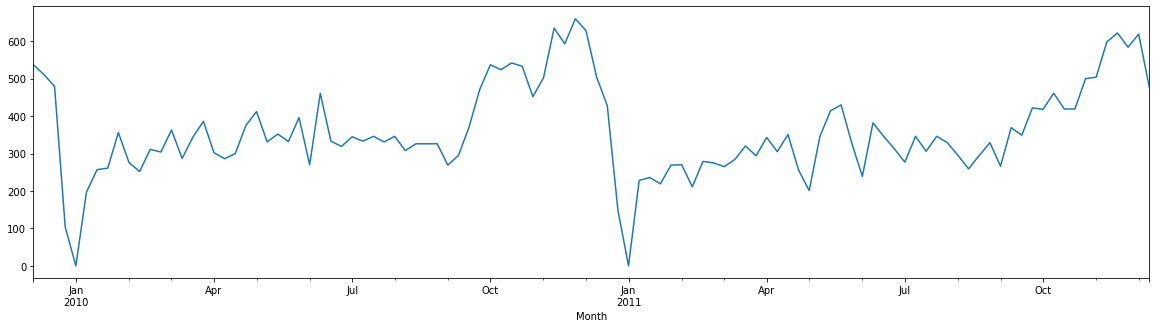

In [302]:
df['Orders per Week'].plot(figsize=(20,5),xlabel='Month');

In [303]:
df.head()

,Orders per Week,Calender Week
Sunday of Week,,
2009-12-06,537,49
2009-12-13,511,50
2009-12-20,479,51
2009-12-27,104,52
2010-01-03,0,53


In [304]:
#Please ignore
#df['Last Week'] = np.where(df['Orders per Week']==0, 1, 0)

### I just plotted the seasonal decomposition again in order to make clear the constitution of the time series

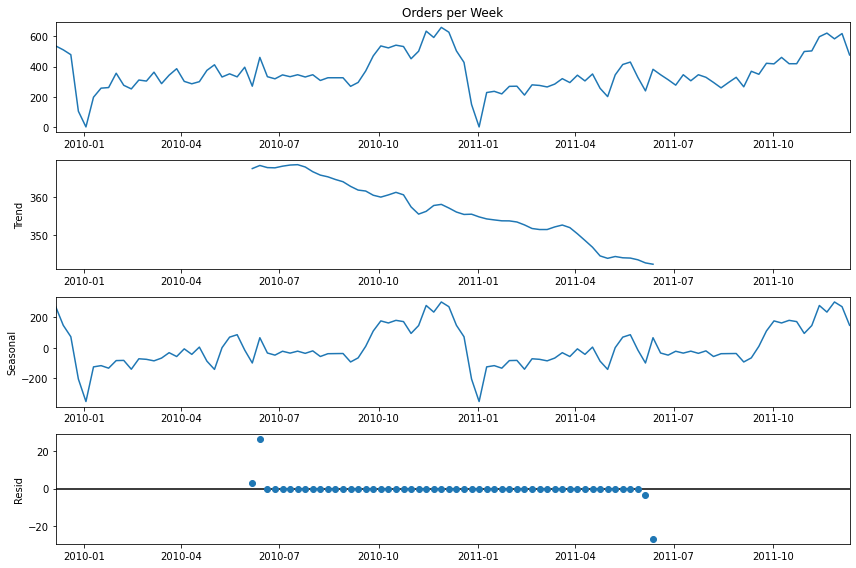

In [305]:
from pylab import rcParams

result1 = seasonal_decompose(df['Orders per Week'], model ='add',period=52)

rcParams['figure.figsize']=12,8
result1.plot();

### As already mentioned in the Notebook for preprocessing, the data follows no obvious trend or seasonality. You can just recognize a very tiny downwards trend and a yearly season with a specific behavior. For choosing the model for prediction this insight is very helpful. So I also plotted the years on top of each other to see if my assumtions can be correct. Although most of the spikes in the data seem to be random noise some similarities exist (e.g. between week 20 and week 25 both years show a sharp drop and a spike after that)

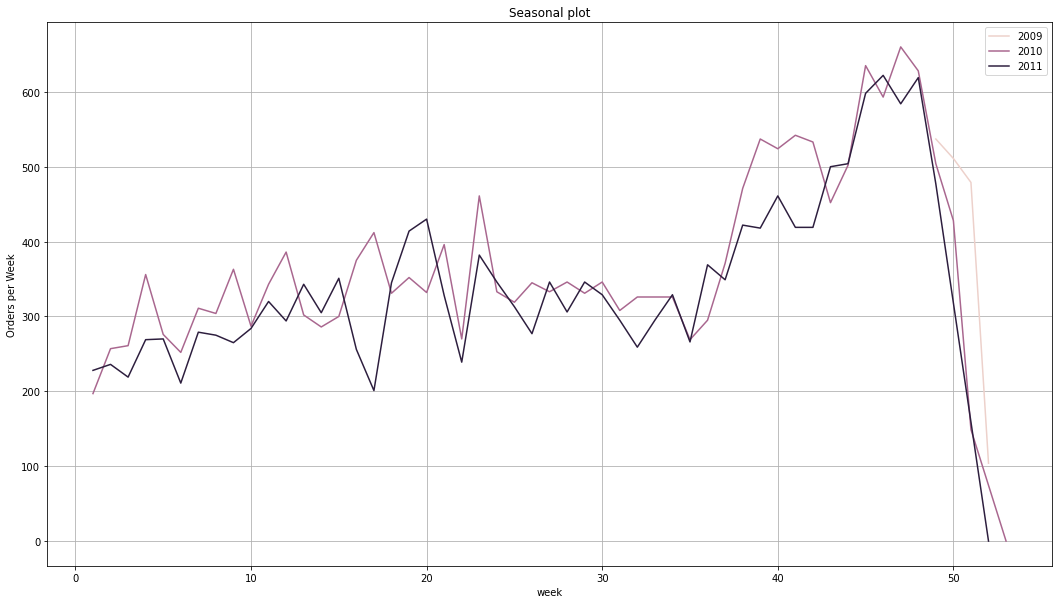

In [306]:
plt.subplots(figsize=(18,10))
sns.lineplot(data=df, 
             x=df.index.isocalendar().week, 
             y='Orders per Week', 
             hue=df.index.year, 
             legend='full')


plt.title('Seasonal plot')


plt.legend();
plt.grid()

### The year 2009 is only represented with it's end. 2010 and 2011 show a common yearly course. By looking at this plot you may also recognize that the slightly downwards trend is really in the data. The weekly sales numers for 2011 are generally below the numbers for 2010 most of the time. By plotting a month plot you can also see this yearly behaviour of the data.

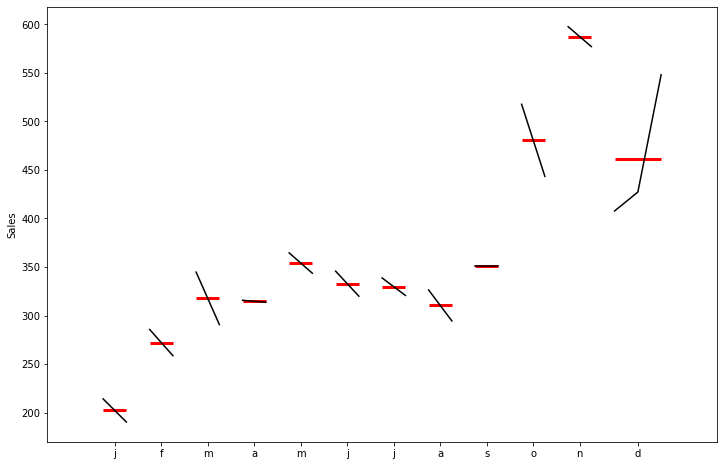

In [307]:
dfm = df['Orders per Week'].resample(rule='M').mean()

month_plot(dfm,ylabel='Sales');

### For this specific task it is more reasonable to learn a smoothed estimation of the yearly course instead of doing a real time series regression. For this reason I picked Triple Exponential Smoothing as my favoured model to predict the future. Additionally I tried a SARIMA model which is also suitable for seasonal behaviour but would need real stationary data. According to statistical tests it is, hence especially the yearly periodicity is important to estimate the border weeks of the year. In our case the data has a yearly season and a slight downwards trend which should be considered - so, I decided against the SARIMA model in the end. 

### Moreover it does not make really sense to do a train test split evaluation of the model because we want to predict the yearly (drop of orders in january) behaviour and not some weeks based on the homogenous behaviour of past data.

In [308]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=10).mean() 
    rolstd = pd.Series(timeseries).rolling(window=10).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

 > Is the raw data stationary ?
Test statistic = -3.767
P-value = 0.003
Critical values :
	1%: -3.4942202045135513 - The data is  stationary with 99% confidence
	5%: -2.889485291005291 - The data is  stationary with 95% confidence
	10%: -2.5816762131519275 - The data is  stationary with 90% confidence


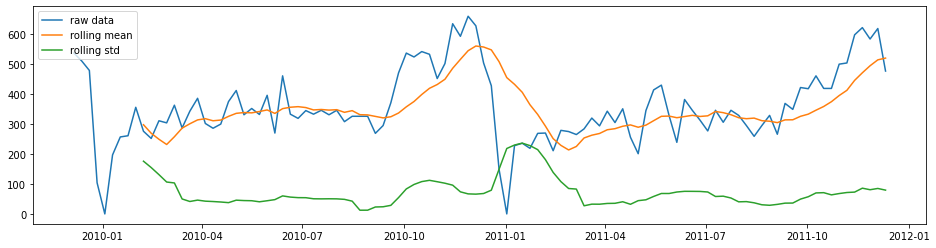

In [309]:
test_stationarity(df['Orders per Week'],'raw data')
ADF_test(df['Orders per Week'],'raw data')

 > Is the 52 lag differenced data stationary ?
Test statistic = -5.457
P-value = 0.000
Critical values :
	1%: -3.5656240522121956 - The data is  stationary with 99% confidence
	5%: -2.920142229157715 - The data is  stationary with 95% confidence
	10%: -2.598014675124952 - The data is  stationary with 90% confidence


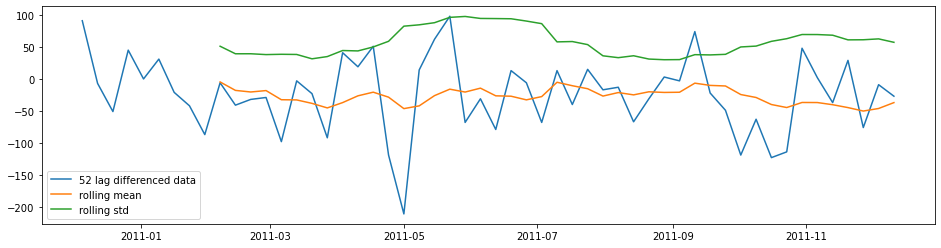

In [310]:
y_52lag =  df['Orders per Week'] - df['Orders per Week'].shift(52)

test_stationarity(y_52lag,'52 lag differenced data')
ADF_test(y_52lag,'52 lag differenced data')

## Triple Exponential Smoothing

### As mentioned we do have a kind of seasonal behaviour on a yearly basis. This is hard to learn for a model when only looking at the raw data with only 1 full season. As I do see cyclical patterns of fixed frequencies this should be considered. Exponential Smoothing is a promising model for this task.

In [311]:
df_es=df.copy()
fitted_model_ES = ExponentialSmoothing(df_es['Orders per Week'],
                                  trend='add',
                                  seasonal='add',
                                seasonal_periods =52
                                      ).fit()

df_es['TES_52']=fitted_model_ES.fittedvalues
predictions = fitted_model_ES.forecast(54)

C:\Users\pgras\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


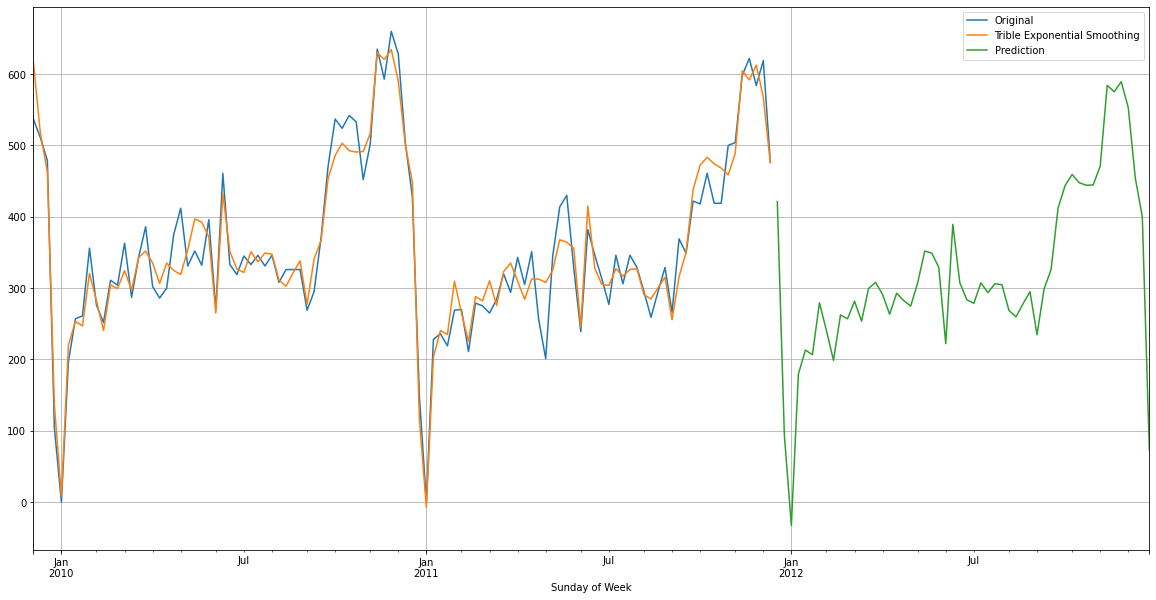

In [312]:
df['Orders per Week'].plot(legend=True,label='Original',figsize=(20,10));

df_es['TES_52'].plot(legend=True,label='Trible Exponential Smoothing');

predictions.plot(legend=True,label='Prediction',grid=True);

### Looking at the plots it seems that the model did a reasonable good job on forecasting the next year. This is what I wanted. I will take this model to predict the next 4 weeks. Only the 0 sales within the last week of the year is not modelled correctly. Here I have to adapt the prediction manually to zero instead of the predicted negative value.


In [313]:
df_future_es=pd.DataFrame(columns=df_es.columns,index=pd.date_range(df_es.index[-1]+ df_es.index.freq, '2012-12-31', freq='W-SUN'))

df_future_es['Orders per Week']=predictions
df_future_es['Calender Week']=df_future_es.index.isocalendar()['week']
dfnew_es=df.append(df_future_es)

<ipython-input-314-7a7016b96cc7>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  x=dfnew_es.index.week,


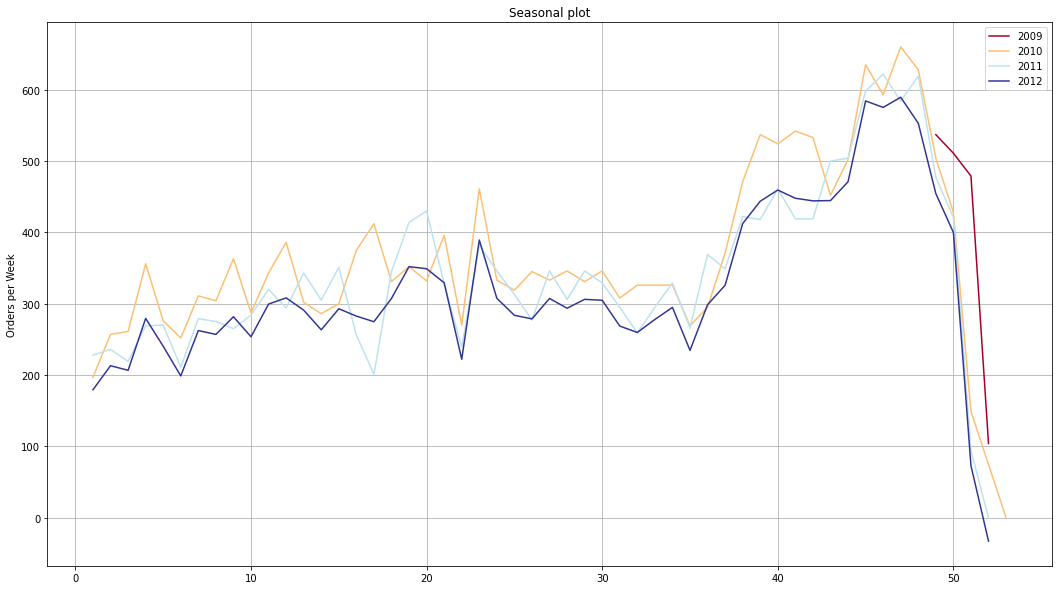

In [314]:
plt.subplots(figsize=(18,10))
sns.color_palette()
sns.lineplot(data=dfnew_es, 
             x=dfnew_es.index.week, 
             y='Orders per Week', 
             hue=dfnew_es.index.year, 
             legend='full',
            palette='RdYlBu')


plt.title('Seasonal plot')


plt.legend();
plt.grid()

### All in all we have our forecast for the end of 2011 and the year 2012 now. It fits well the yearly season and also considers the slight downwards trend between the years. Between week 20 and 25 the years 2010 and 2011 show similar behaviour - a sudden drop and a steep rise after that. Even that "learned" by the model. I considered this as my best model as SARIMA doesn't work that well on this specific dataset. I think this is because there is no repeated seasonality.

In [315]:
df_future_es['Orders per Week'] = np.where(df_future_es['Orders per Week']<0, 0,df_future_es['Orders per Week'])


cols=['Orders per Week','Calender Week']

df_future_es[cols].iloc[:4]

,Orders per Week,Calender Week
2011-12-18,421.091934,50
2011-12-25,94.161219,51
2012-01-01,0.000000,52
2012-01-08,179.413021,1


In [316]:
df.loc[(df['Calender Week']>=50)|(df['Calender Week']<2)]

,Orders per Week,Calender Week
Sunday of Week,,
2009-12-13,511,50
2009-12-20,479,51
2009-12-27,104,52
2010-01-03,0,53
2010-01-10,197,1
2010-12-19,428,50
2010-12-26,149,51
2011-01-02,0,52
2011-01-09,228,1


In [317]:
df_future_es[cols].iloc[:4]['Orders per Week'].round()

2011-12-18    421.0
2011-12-25     94.0
2012-01-01      0.0
2012-01-08    179.0
Freq: W-SUN, Name: Orders per Week, dtype: float64

### By looking at the sales numbers the estimation seems also to be reasonable. My predicted sales values for the next 4 weeks are: 421 for Week 50-2011, 94 for week 51-2011, 0 for week 52-2011 and 179 for week 1-2012

### For more accurate forecasts it would be important to have more year seasons in our data. So, the data would probably have a clear seasonality.